In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Using the bengaluru housing data from kaggle, we will build a series of machine learning models to help predict the price of houses. We will not be using deep learning models in this project.

In [2]:
path = 'Bengaluru_House_Data.csv'
df = pd.read_csv(path)
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


### 1st we need to clean our data and let's see how many examples and features we are working with.

In [3]:
df.shape

(13320, 9)

#### So we have 13,320 examples to work with and 8 features (minus 1 because of the price, which will be our target variable)

In [4]:
#Let's see what features have na values
df.isna().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [5]:
#Let's see how many area types there are and how many are in each catagory
df.groupby('area_type')['area_type'].count() #This says I want to group [] by ()

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

#### Well, let's say we decided we don't want to use all the columns of info we have up top. Let's drop the ones we don't want.

In [6]:
features_to_dispose = ['area_type', 'society', 'balcony', 'availability']
df2 = df.drop(features_to_dispose, axis = 'columns')
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [7]:
## Now what na values do we have?
df2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [8]:
#Let's drop all of these na values because we have 13,320 examples, losing 90 is not a big deal
df2.dropna(inplace = True)

In [9]:
df2.isna().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [10]:
df2.shape

(13246, 5)

In [11]:
#Now let's look at the size feature because it looks like we have a lot of different types of values
df2['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [12]:
## 4 Bedroom is the same as 4BHK, so let's make a uniform nameing convention by just taking the first number
df2['bhk'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))

In [13]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [14]:
df2['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [15]:
#Let's see what the >20 bedroom house looks like
df2[df2.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [16]:
##Well, the 43 bedroom house is probably a mistake since it only has 2400 sqft

In [17]:
##Let's see what types of total_sqft we have
df2['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [18]:
## You can see above we have a 1133-1384 value which is giving us a range, we want to get rid of it, so let's take its average
## and replace the range with the average
## Let's find which ones we can turn into floats first
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

df2[~df2['total_sqft'].apply(is_float)].head(10) #The tilde is a negation operator and says give me all the ones that can't be applied.

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [19]:
##Let's write a python function that takes the range and returns a float of the average
def take_range_give_mean(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [20]:
take_range_give_mean('2166')

2166.0

In [21]:
take_range_give_mean('2166-2199')

2182.5

In [22]:
take_range_give_mean('34.46Sq Meter')

In [23]:
df2['total_sqft'] = df2['total_sqft'].apply(take_range_give_mean)

In [24]:
df2.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [25]:
## Now let's drop all rows of total_sqft that are None and let's drop the size columns
df2.drop('size', axis='columns', inplace=True)

In [26]:
df2.shape

(13246, 5)

In [27]:
df2.dropna()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5
13316,Richards Town,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


In [28]:
#We dropped another 46 rows.

In [29]:
#now let's do some feature engineering, like making a new column that tells price per sqft.
df2['price_per_sqft'] = df2['price']*100000/df2['total_sqft']
df2.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [30]:
len(df2.location.unique())

1304

In [31]:
#So we have 1304 unique locations that homes are found in. Normally we would one hot encode this but that would add 1303
#(we get rid of one to avoid the dummy variable trap) columns. So instead let's come up with an 'other' category which accounts
#for those locations which don't have many houses found there

#First let's strip the whitespace
df2.location = df2.location.apply(lambda x : x.strip())

location_stats = df2.groupby('location')['location'].count().sort_values(ascending = False)
location_stats

location
Whitefield               535
Sarjapur  Road           392
Electronic City          304
Kanakpura Road           266
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Karnataka Shabarimala      1
whitefiled                 1
Name: location, Length: 1293, dtype: int64

In [32]:
#Let's say that any place with 10 or less locations is in the 'other' category.
len(location_stats[location_stats<=10])

1052

In [33]:
location_less_than_10 = location_stats[location_stats<=10]

In [34]:
df2.location = df2.location.apply(lambda x: 'other' if x in location_less_than_10 else x)

In [35]:
len(df2.location.unique())

242

In [36]:
#Now 242 is a much better dimensionality than 1304 for when we one hot encode this

In [37]:
#Let's also check how many sqft we have per bedroom, and if it is less than 300, we want to see it
df2[df2.total_sqft/df2.bhk<300].head()

,location,total_sqft,bath,price,bhk,price_per_sqft
9,other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,other,500.0,3.0,100.0,3,20000.000000


In [38]:
df2.shape

(13246, 6)

In [39]:
df2 = df2[~(df2.total_sqft/df2.bhk<300)]
df2.shape

(12502, 6)

In [40]:
#Let's also remove any extreme sqft pricings
df2.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [41]:
## We want to find the std dev of sqft PER location and filter out everything beyond 1 std dev.

def remove_pps_outlier(dataframe):
    df_out = pd.DataFrame()
    for key, subdf in dataframe.groupby('location'):
        mean = subdf['price_per_sqft'].mean()
        std = subdf['price_per_sqft'].std()
        reduced_df = subdf[(subdf.price_per_sqft>(mean-std)) & (subdf.price_per_sqft<=(mean+std))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

In [42]:
df3 = remove_pps_outlier(df2)

In [43]:
df3.shape

(10291, 6)

In [44]:
#Now we want to see if any 2 bedrooms prices with similar sqft to 3 bedroom locations is more expensive or not
def plot_scatter_chart(df, location):
    two_beds = df[(df.location==location) & (df.bhk == 2)]
    three_beds = df[(df.location==location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(two_beds.total_sqft, two_beds.price, color='blue', label = '2 beds', s=50)
    plt.scatter(three_beds.total_sqft, three_beds.price, color='green', label = '3 beds', s=50, marker = '+')
    plt.xlabel('Total Square Foot Area')
    plt.ylabel('Price')
    plt.title(location)
    

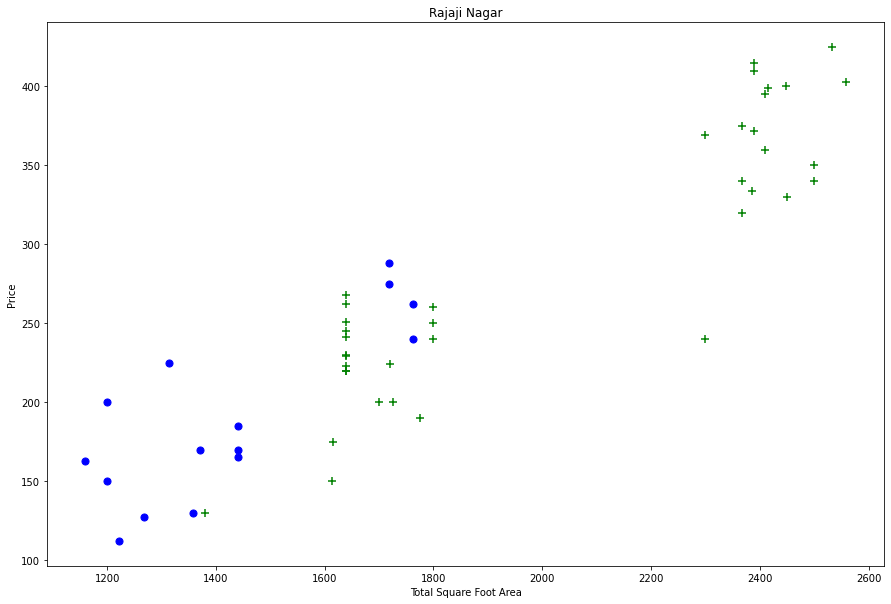

In [45]:
plot_scatter_chart(df3, 'Rajaji Nagar')

#### Let's build a function that will create a dictionary of statistics for each location and then at each location is will find the mean, standard deviation and count.

#### { 
    '1' : {
          'mean' : 4000,
         'std' : 168.2,
         'count' : 34
     },
     '2' ....
#### }

#### Then with the dictionary of information we will use it to filter our information. For all 2 bedrooms, if their price is less than the average of 1 bedroom, remove. For all 3 bedrooms if their price is less than the average of 2 bedrooms, then remove. Etc.. And this is per location.

In [46]:
def remove_bhk_outliers(dataframe):
    exclude_indices = np.array([])
    for location, location_df in dataframe.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': bhk_df.price_per_sqft.mean(),
                'std' : bhk_df.price_per_sqft.std(),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return dataframe.drop(exclude_indices, axis = 'index')

In [47]:
df4 = remove_bhk_outliers(df3)
df4.shape

(7376, 6)

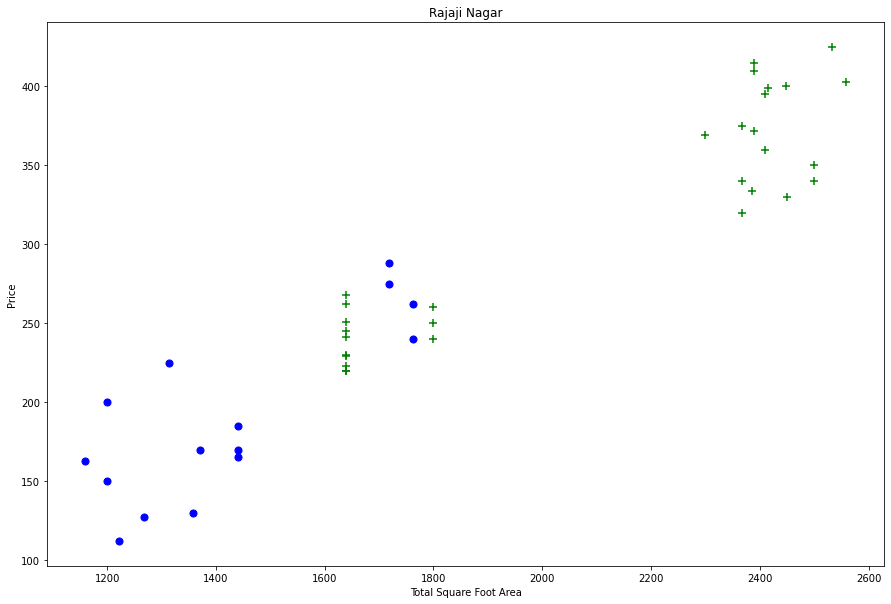

In [48]:
plot_scatter_chart(df4, 'Rajaji Nagar')

In [49]:
df4.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,1235.0,2.0,148.0,2,11983.805668


In [50]:
## Now let's say we talked to our domain expert and they said to remove all locations that have bathrooms greater than the 
## the amount of bedrooms + 2

df5 = df4[df4.bath<df4.bhk+2]
df5.shape

(7297, 6)

In [51]:
#Now let's drop price_per_sqft and we will be ready for training
df5.drop('price_per_sqft',axis='columns' , inplace=True)
df5.head()

C:\Users\ashri\AppData\Local\Temp\ipykernel_18708\3257992049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.drop('price_per_sqft',axis='columns' , inplace=True)


,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [52]:
# Now lets get to building a selecting models.
# First we have to import some libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [53]:
#First let's convert our location columns into a One Hot Encoding
# we could use from sklearn.preprocessing import OneHotEncoder
#But Pandas actually comes with a built in method called .get_dummies so we will use that
loc_dummies = pd.get_dummies(df5.location, drop_first=True) #We drop one to avoid the dummy variable trap
loc_dummies.head()

,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Now let's concat them to our dataframe
df6 = pd.concat([df5, loc_dummies], axis = 'columns')
df6.drop('location', axis = 'columns', inplace = True)
df6.head()

,total_sqft,bath,price,bhk,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,2850.0,4.0,428.0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
df6.shape

(7297, 245)

In [71]:
#Now we can make our data sets.
X = df6.drop('price', axis = 'columns')
y = df6.price
X.head()

,total_sqft,bath,bhk,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,2850.0,4.0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [58]:
#Let's see how it does on linear model
lin_clf = LinearRegression()
lin_clf.fit(x_train, y_train)
lin_clf.score(x_test, y_test)

0.793808959150282

In [59]:
cv = ShuffleSplit(n_splits=5, test_size =0.2, random_state=0)
lin_scores = cross_val_score(LinearRegression(), X, y, cv=cv)
lin_scores

array([0.79156627, 0.80518683, 0.8623199 , 0.83998208, 0.8676077 ])

In [60]:
np.mean(lin_scores)

0.8333325566169674

In [61]:
#Not a bad Average Score

In [62]:
#Now let's use gridsearchcv to find (albietly through a small area of parameters) a model.
algs = {
    'linear_regression' : {
        'model' : LinearRegression(),
        'params' : {
            'normalize' : [True, False]
        }
    },
    'lasso' : {
        'model' : Lasso(),
        'params' : {
            'alpha' : [1,2],
            'selection' : ['random', 'cyclic']
        }
    },
    'decision_tree' : {
        'model' : DecisionTreeRegressor(),
        'params': {
            'criterion' : ['mse', 'friedman_mse'],
            'splitter' : ['best', 'random']
        }
    }
}

In [66]:
scores = []

for model, mp in algs.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv = cv, return_train_score=False)
    clf.fit(X, y)
    scores.append({
        'model' : model,
        'best_score' : clf.best_score_,
        'best_params' : clf.best_params_
    })

C:\Users\ashri\anaconda3\envs\TensorflowMachineLearning\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\ashri\anaconda3\envs\TensorflowMachineLearning\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous 

C:\Users\ashri\anaconda3\envs\TensorflowMachineLearning\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\ashri\anaconda3\envs\TensorflowMachineLearning\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(
C:\Users\ashri\anaconda3\envs\TensorflowMachineLearning\lib\site-packages\sklearn\tree\_classes.py:359: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warnings.warn(


In [67]:
scores

[{'model': 'linear_regression',
  'best_score': 0.8333325566169674,
  'best_params': {'normalize': False}},
 {'model': 'lasso',
  'best_score': 0.690292223603824,
  'best_params': {'alpha': 1, 'selection': 'random'}},
 {'model': 'decision_tree',
  'best_score': 0.7940207033820265,
  'best_params': {'criterion': 'mse', 'splitter': 'random'}}]

In [70]:
scores_df = pd.DataFrame(scores, columns = ['model', 'best_scores', 'best_params'])
scores_df

,model,best_scores,best_params
0,linear_regression,NaN,{'normalize': False}
1,lasso,NaN,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,NaN,"{'criterion': 'mse', 'splitter': 'random'}"


In [74]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >=0:
        x[loc_index] = 1
    
    return lin_clf.predict([x])[0]

In [75]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

C:\Users\ashri\anaconda3\envs\TensorflowMachineLearning\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


84.88170139812661

In [76]:
#Now let's export this to a pickle file.
import pickle
with open('banglore_home_price_predictions.pickle', 'wb') as f:
    pickle.dump(lin_clf, f)

In [77]:
## We also want to make sure we export the column name information too and we will do that with a json file
import json
columns = {
    'data columns' : [col.lower() for col in X.columns]
}

with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))

In [78]:
# Now we will write a python flask server that which can serve http requests from the UI 